In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
%matplotlib inline

# 514 Programming Assignment 2
#### Group: Rashaan, Ravi, David

Data additional information
Each record is an example of a hand consisting of five playing cards drawn from a standard deck of 52. 
Each card is described using two attributes (suit and rank), for a total of 10 predictive attributes. 
There is one Class attribute that describes the "Poker Hand". 
The order of cards is important, which is why there are 480 possible Royal Flush hands as compared to 4

#### Load dataset

In [37]:
# Column names for the dataset
# Define the column names for your dataset
columns = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'Class']

# Load your dataset
training_data = pd.read_csv('poker-hand-training-true.csv', header=None, names=columns)
testing_data = pd.read_csv('poker-hand-testing.csv', header=None, names=columns)

# Adjust the ranks of cards, specifically changing Ace from 1 to 14
def adjust_ranks(data):
    for i in range(1, 6):  # For each card in the hand
        data[f'C{i}'] = data[f'C{i}'].apply(lambda x: 14 if x == 1 else x)
    return data

# One-hot encode the suits of the cards
def one_hot_encode_suits(data):
    for i in range(1, 6):  # For each card in the hand
        data = pd.concat([data, pd.get_dummies(data[f'S{i}'], prefix=f'S{i}')], axis=1).drop([f'S{i}'], axis=1)
    return data

# Apply preprocessing steps
def preprocess_data(data):
    data = adjust_ranks(data)
    data = one_hot_encode_suits(data)
    return data

training_data_preprocessed = preprocess_data(training_data)
testing_data_preprocessed = preprocess_data(testing_data)


# Naïve Bayes Classifier - Part B

In [38]:
from sklearn.naive_bayes import CategoricalNB,BernoulliNB,MultinomialNB
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,classification_report,confusion_matrix

##### PREPARE THE TRAINING AND TESTING SETS

In [39]:
x_train = training_data_preprocessed[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_train = pd.DataFrame(training_data_preprocessed['Class'])

x_test = testing_data_preprocessed[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_test = pd.DataFrame(testing_data_preprocessed['Class'])

In [40]:
def adjust_class(data):
        bad,good,great = 0,4,9
        #BAD
        data['Class'] = data['Class'].apply(lambda x: bad if x == 0 else x)
        data['Class'] = data['Class'].apply(lambda x: bad if x == 1 else x)
        data['Class'] = data['Class'].apply(lambda x: bad if x == 2 else x)
        data['Class'] = data['Class'].apply(lambda x: bad if x == 3 else x)
        #GOOD
        data['Class'] = data['Class'].apply(lambda x: good if x == 4 else x)
        data['Class'] = data['Class'].apply(lambda x: good if x == 5 else x)
        data['Class'] = data['Class'].apply(lambda x: good if x == 6 else x)
        #GREAT
        data['Class'] = data['Class'].apply(lambda x: great if x == 7 else x)
        data['Class'] = data['Class'].apply(lambda x: great if x == 8 else x)
        data['Class'] = data['Class'].apply(lambda x: great if x == 9 else x)
        return data

In [41]:
prior = [0.33,0.33,0.33]
cnb = CategoricalNB(alpha=0.0000000001,force_alpha=True,class_prior=prior)

In [42]:
def five_fold_CV_NBC(x_train,y_train,x_test,y_test):
    ### FOLDS ####
    folds = KFold(n_splits=5, shuffle=True, random_state=2)
    cv_folds = folds.split(x_train,y_train)
    x_,y_,x_t,y_t = [],[],[],[]
    for i, (train_index, test_index) in enumerate(cv_folds):
        temp_x,temp_y = copy.deepcopy(x_train.iloc[train_index]),copy.deepcopy(y_train.iloc[train_index])
        temp_x_test,temp_y_test = copy.deepcopy(x_train.iloc[test_index]),copy.deepcopy(y_train.iloc[test_index])
        x_.append(temp_x)
        y_.append(temp_y)
        x_t.append(temp_x_test)
        y_t.append(temp_y_test)
    #FOLD 1
    x_train_float_fold1 = x_[0]
    y_train_float_fold1 = adjust_class(y_[0]).values.ravel()
    
    x_train_float_fold1_t = x_t[0]
    y_train_float_fold1_t = adjust_class(y_t[0]).values.ravel()

    #FOLD 2
    x_train_float_fold2 = x_[1]
    y_train_float_fold2 = adjust_class(y_[1]).values.ravel()
    
    x_train_float_fold2_t = x_t[1]
    y_train_float_fold2_t = adjust_class(y_t[1]).values.ravel()
    
    #FOLD 3
    x_train_float_fold3 = x_[2]
    y_train_float_fold3 = adjust_class(y_[2]).values.ravel()
    
    x_train_float_fold3_t = x_t[2]
    y_train_float_fold3_t = adjust_class(y_t[2]).values.ravel()

    #FOLD 4
    x_train_float_fold4 = x_[3]
    y_train_float_fold4 = adjust_class(y_[3]).values.ravel()
    
    x_train_float_fold4_t = x_t[3]
    y_train_float_fold4_t = adjust_class(y_t[3]).values.ravel()

    #FOLD 5
    x_train_float_fold5 = x_[4]
    y_train_float_fold5 = adjust_class(y_[4]).values.ravel()
    
    x_train_float_fold5_t = x_t[4]
    y_train_float_fold5_t = adjust_class(y_t[4]).values.ravel()
    
    
    ### TESTING ###
    models = []
    loss = []
    scores = []
    mod_score = []
    pred,curr_err = 0,0
    error = []
    acc = []
    
    #########
    w_ = np.ones(20008)/3
    class_ = [0,4,9]
    
    ###### 1 #######
    model1 = cnb.partial_fit(x_train_float_fold1,y_train_float_fold1,classes=class_,sample_weight=w_)
    models.append(model1)
    mod_score.append(model1.score(x_train_float_fold1,y_train_float_fold1))
    scores.append(cross_val_score(model1, x_train_float_fold1_t, y_train_float_fold1_t, scoring='accuracy'))
    pred = model1.predict(x_train_float_fold1_t)
    curr_err = mean_squared_error(y_train_float_fold1_t,pred)
    error.append(curr_err)
    acc.append(accuracy_score(y_train_float_fold1_t,pred))
    
    ###### 2 #######
    model2 = copy.deepcopy(model1)
    model2 = cnb.partial_fit(x_train_float_fold2,y_train_float_fold2,classes=class_)
    models.append(model2)
    mod_score.append(model2.score(x_train_float_fold2_t,y_train_float_fold2_t))
    scores.append(cross_val_score(model2, x_train_float_fold2_t, y_train_float_fold2_t, scoring='accuracy'))
    pred = model2.predict(x_train_float_fold2_t)
    curr_err = mean_squared_error(y_train_float_fold2_t,pred)
    error.append(curr_err)
    acc.append(accuracy_score(y_train_float_fold2_t,pred))
    
    ###### 3 #######
    model3 = copy.deepcopy(model2)
    model3 = cnb.partial_fit(x_train_float_fold3,y_train_float_fold3,classes=class_)
    models.append(model3)
    mod_score.append(model3.score(x_train_float_fold3_t,y_train_float_fold3_t))
    scores.append(cross_val_score(model3, x_train_float_fold3_t, y_train_float_fold3_t, scoring='accuracy'))
    pred = model3.predict(x_train_float_fold3_t)
    curr_err = mean_squared_error(y_train_float_fold3_t,pred)
    error.append(curr_err)
    acc.append(accuracy_score(y_train_float_fold3_t,pred))
    
    ###### 4 #######
    model4 = copy.deepcopy(model3)
    model4 = cnb.partial_fit(x_train_float_fold4,y_train_float_fold4,classes=class_)
    models.append(model4)
    mod_score.append(model4.score(x_train_float_fold4_t,y_train_float_fold4_t))
    scores.append(cross_val_score(model4, x_train_float_fold4_t, y_train_float_fold4_t, scoring='accuracy'))
    pred = model4.predict(x_train_float_fold4_t)
    curr_err = mean_squared_error(y_train_float_fold4_t,pred)
    error.append(curr_err)
    acc.append(accuracy_score(y_train_float_fold4_t,pred))
    
    ###### 5 #######
    model5 = copy.deepcopy(model4)
    model5 = cnb.partial_fit(x_train_float_fold5,y_train_float_fold5,classes=class_)
    models.append(model5)
    mod_score.append(model5.score(x_train_float_fold5,y_train_float_fold5))
    scores.append(cross_val_score(model5, x_train_float_fold5_t, y_train_float_fold5_t, scoring='accuracy'))
    pred = model5.predict(x_train_float_fold5_t)
    curr_err = mean_squared_error(y_train_float_fold5_t,pred)
    error.append(curr_err)
    acc.append(accuracy_score(y_train_float_fold5_t,pred))
    
    return models,scores,error,acc,mod_score

In [43]:
models,scores,error,acc,mod_score = five_fold_CV_NBC(x_train,y_train,x_test,y_test)

/Users/rashaanyapp/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/rashaanyapp/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rashaanyapp/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rashaanyapp/anaconda3/lib/python3.11/site-packages/sklearn/

In [44]:
def plot_score(data,fig,side):
    colors = ['r','g','b','k','c']
    plt.plot(pd.DataFrame(data))
    for i in range(len(data)):
        plt.plot(i,data[i],colors[i],label='fold '+str(i),marker='o')
    plt.title("Naïve Bayes Classifier Model: 5Fold-CV: " + str(fig) + " vs Iteration")
    plt.xlabel("iteration")
    plt.ylabel(str(fig))
    plt.legend(loc="upper "+side)
    plt.show()

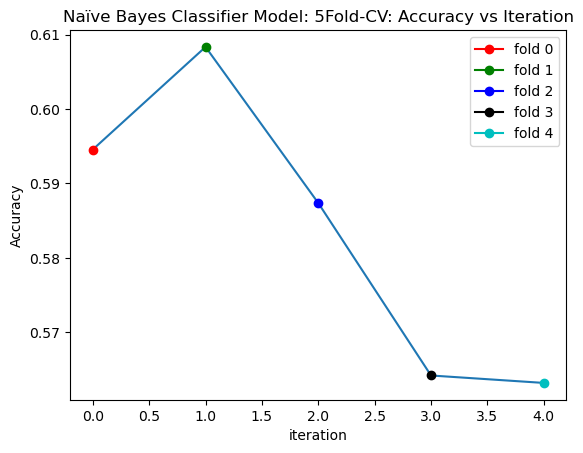

In [45]:
plot_score(acc,'Accuracy','right')